### Aim:

In this notebook, SVM algorithm (linear vs radial kernels) will be used to evaluate what additive effect (if any) ToxCast targets provide *for predicting mostDILI drugs* - when compared to existing predictors currently used in the field (eg: Chen M et al., 2016 Hepatol, Shah F et al., 2015 Toxicol Sci).

Since same test/train data is used for this modeling and others, the results of SVM will be compared against performance using alternative algorithms used (eg: logistic regression, random forest, gradient boosting, etc). 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
plt.style.use('seaborn') 

%matplotlib inline

import pandas_profiling

C:\Users\Sri Bandhakavi\Anaconda3\lib\site-packages\pandas_profiling\plot.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\Users\Sri Bandhakavi\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Sri Bandhakavi\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Sri Bandhakavi\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Sri Bandhakavi\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\Sri Bandhakavi\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 478, 

In [2]:
#magic command to print all output instead of only last line
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Read-in datasets, prepare data for ML

All datasets have been previously treated for missing values and dummy coding of categorical variables(reactive_metabolites, classificn, and ~216 toxcast targets).
Output/target/Y variable for modeling purposes is "classificn" (1="mostDILI", 0 = "other" which includes lessDILI/ambiDILI/noDILI). <br>

In this notebook, same datasets previously used for logistic regression modeling will be imported. No EDA will be performed as the datasetts are identical to those previously used and EDA has already been done within the notebook using logistic regression as initial model.

Data once imported will be transformed into feature dataset ("X") and label dataset ("Y") and further split using stratified sampling with call to test train split function. For allowing to compare results across algorithms evaluated, same random state will be used as before.

In [3]:
mc = pd.read_csv("mc_scaled_labeled.csv")
tc = pd.read_csv("tc_pca_labeled.csv")
mc_tc=pd.read_csv("mctc_pca_labeled.csv")

In [4]:
#Create "x" consisting of all independent variables from each of the dataframes (mc, tc, mc_tc) to be used for modeling

mc_num=mc.select_dtypes(include=[np.number])
x_mc=mc_num.drop(["classificn"], axis=1)

tc_num=tc.select_dtypes(include=[np.number])
x_tc=tc_num.drop(["classificn"], axis=1)

mc_tc_num=mc_tc.select_dtypes(include=[np.number])
x_mc_tc=mc_tc_num.drop(["classificn"], axis=1)

In [5]:
#create "y" consisting of outcome/target variable from each of the dataframes (mc, tc, mc_tc) to be used for modeling

y_mc=mc_num["classificn"] 
y_tc=tc_num["classificn"]
y_mc_tc=mc_tc_num["classificn"]

#check to make sure all datasets are equivalent for classification column
y_mc.equals(y_tc)
y_mc.equals(y_mc_tc)
y_tc.equals(y_mc_tc)

#breakdown of mostDILI drugs vs other drugs
y_mc.value_counts()#60 drugs are labeled as "mostDILI" and 115 drugs as "other"

True

True

True

0    115
1     60
Name: classificn, dtype: int64

In [6]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics

## test train stratified split at 40:60 ratio (maintains ratio of mostDILI drugs:other drugs)
# allows for testing on 24 "mostDILI" and training on 36 "mostDILI" drugs
train_mcx, test_mcx, train_mcy, test_mcy = train_test_split(x_mc,y_mc, stratify=y_mc, test_size=0.4, random_state=45)

train_tcx, test_tcx, train_tcy, test_tcy = train_test_split(x_tc,y_tc, stratify=y_tc, test_size=0.4, random_state=45)

train_mctcx, test_mctcx, train_mctcy, test_mctcy = train_test_split(x_mc_tc,y_mc_tc, stratify=y_mc_tc, test_size=0.4, random_state=45)

#confirm that test datasets are same across all splits
test_mctcy.equals(test_tcy)
test_mcy.equals(test_tcy)

True

True

### SVM - initial model

In [7]:
# Initial model - Instantiate & Fit
from sklearn.svm import SVC

svm_mc = SVC(probability=True, class_weight='balanced') 
svm_tc = SVC(probability=True, class_weight='balanced')
svm_mctc = SVC(probability=True, class_weight='balanced')
        #need to check probability=True so as to allow for predict_proba function and plots of ROC-AUC curve

svm_mc.fit(train_mcx, train_mcy) 
svm_tc.fit(train_tcx, train_tcy)
svm_mctc.fit(train_mctcx, train_mctcy)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#### Tune SVM model for each of the datasets

In [8]:
Cs = [0.25, 0.5, 1,2,5, 10, 15]
gammas = [0.000001, 0.00001, 0.01, 1]
kernels = ['rbf', 'linear']
param_grid = {'C': Cs, 'gamma' : gammas, 'kernel' : kernels}

In [9]:
from sklearn.grid_search import GridSearchCV

grid_mc = GridSearchCV(svm_mc, param_grid,cv=3, scoring='roc_auc', n_jobs=-1)
grid_tc = GridSearchCV(svm_tc, param_grid, cv=3,scoring='roc_auc', n_jobs=-1)
grid_mctc= GridSearchCV(svm_mctc, param_grid, cv=3,scoring='roc_auc', n_jobs=-1)

C:\Users\Sri Bandhakavi\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Sri Bandhakavi\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [10]:
#"fit" grid search models (commented out - to avoid re-implementation)
#grid_mc.fit(train_mcx,train_mcy)
#grid_tc.fit(train_tcx, train_tcy)
#grid_mctc.fit(train_mctcx, train_mctcy)

#above code was implemented and optimal parameters retrieved to generate optimal SVC models below. After this, the code was commented out to avoid re-implementation.

In [11]:
print("SVM best params follow below - mc data ")
#grid_mc.best_params_
print("")

print("SVM best params follow below - tc data ")
#grid_tc.best_params_
print("")

print("SVM best params follow below - mctc data ")
#grid_mctc.best_params_
print("")

SVM best params follow below - mc data 

SVM best params follow below - tc data 

SVM best params follow below - mctc data 



#### Optimized SVM model for each dataset

In [12]:
#Instantiate random forest models with optimal parameters
svm_mc = SVC(kernel='linear', probability=True, class_weight='balanced', gamma=1e-06,C=2, random_state = 1)
svm_tc = SVC(kernel='linear',probability=True, class_weight='balanced', gamma=1e-06,C=1, random_state = 1)
svm_mctc = SVC(kernel='linear', probability=True, class_weight='balanced', gamma=1e-06,C=0.5, random_state = 1)

In [13]:
#Fit data to optimal model parameters
svm_mc.fit(train_mcx, train_mcy)
svm_tc.fit(train_tcx, train_tcy)
svm_mctc.fit(train_mctcx, train_mctcy)

SVC(C=2, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1e-06, kernel='linear',
  max_iter=-1, probability=True, random_state=1, shrinking=True, tol=0.001,
  verbose=False)

SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1e-06, kernel='linear',
  max_iter=-1, probability=True, random_state=1, shrinking=True, tol=0.001,
  verbose=False)

SVC(C=0.5, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1e-06, kernel='linear',
  max_iter=-1, probability=True, random_state=1, shrinking=True, tol=0.001,
  verbose=False)

In [14]:
#Predict classification labels based on optimal model parameters

### Using optimized SVM model fitted using variables from Chen et al (mc), predict test values and probabilities  mc
svm_pred_mcy=svm_mc.predict(test_mcx) 
svm_probs_mcy=svm_mc.predict_proba(test_mcx) 

### Using optimized SVM model fitted using variables from ToxCast (tc), predict test values and probabilities  mc
svm_pred_tcy=svm_tc.predict(test_tcx) 
svm_probs_tcy=svm_tc.predict_proba(test_tcx) 

### Using optimized SVM model fitted using variables from Chen et al & ToxCast (mctc), predict test values and probabilities  mc
svm_pred_mctcy=svm_mctc.predict(test_mctcx) 
svm_probs_mctcy=svm_mctc.predict_proba(test_mctcx)  

#### Optimal SVM model metrics for each dataset

In [15]:
from sklearn.model_selection import cross_val_score

svm_accuracy_scores_mc = cross_val_score(svm_mc, x_mc, y_mc, cv=3, scoring='precision')
print("Accuracy: 3-fold cross validation scores on SVM model using mc (Chen M et al., 2016 Hepatol) variables")
print(svm_accuracy_scores_mc)
print("Accuracy mean: " +str(svm_accuracy_scores_mc.mean()), "Accuracy standard deviation: " + str(svm_accuracy_scores_mc.std()))
print("")

svm_accuracy_scores_tc = cross_val_score(svm_tc, x_tc, y_tc, cv=3, scoring='precision')
print("Accuracy: 3-fold cross validation scores on SVM model using tc (ToxCast targets/pathways) variables")
print(svm_accuracy_scores_tc)
print("Accuracy mean: " +str(svm_accuracy_scores_tc.mean()), "Accuracy standard deviation: " + str(svm_accuracy_scores_tc.std()))
print("")

svm_accuracy_scores_mctc = cross_val_score(svm_mctc, x_mc_tc, y_mc_tc, cv=3, scoring='precision')
print("Accuracy: 3-fold cross validation scores on SVM model using combined mc and tc (Chen M et al, 2016 Hepatol and ToxCast) variables")
print(svm_accuracy_scores_mctc)
print("Accuracy mean: " +str(svm_accuracy_scores_mctc.mean()), "Accuracy standard deviation: " + str(svm_accuracy_scores_mctc.std()))

Accuracy: 3-fold cross validation scores on SVM model using mc (Chen M et al., 2016 Hepatol) variables
[0.4516129  0.42857143 0.48275862]
Accuracy mean: 0.45431431749563006 Accuracy standard deviation: 0.02220414641018363

Accuracy: 3-fold cross validation scores on SVM model using tc (ToxCast targets/pathways) variables
[0.5        0.28571429 0.47368421]
Accuracy mean: 0.4197994987468672 Accuracy standard deviation: 0.09541929734737582

Accuracy: 3-fold cross validation scores on SVM model using combined mc and tc (Chen M et al, 2016 Hepatol and ToxCast) variables
[0.52631579 0.47058824 0.55555556]
Accuracy mean: 0.5174865267744525 Accuracy standard deviation: 0.03524512531742485


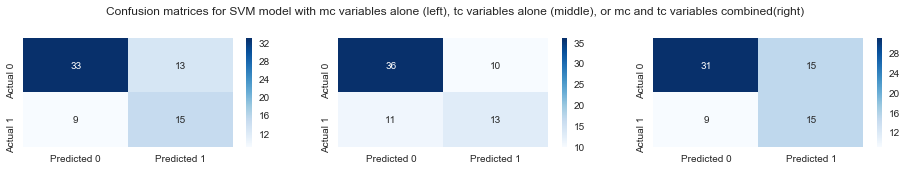

In [16]:
### Confusion Matrix
svm_cfm_mc=metrics.confusion_matrix(test_mcy, svm_pred_mcy)
svm_cfm_tc=metrics.confusion_matrix(test_tcy, svm_pred_tcy)
svm_cfm_mctc=metrics.confusion_matrix(test_mctcy, svm_pred_mctcy)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,2))

lbl1=["Predicted 0", "Predicted 1"]
lbl2=["Actual 0", "Actual 1"]

sns.heatmap(svm_cfm_mc, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2, ax=ax1)
sns.heatmap(svm_cfm_tc, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2, ax=ax2)
sns.heatmap(svm_cfm_mctc, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2, ax=ax3)


fig.suptitle("Confusion matrices for SVM model with mc variables alone (left), tc variables alone (middle), or mc and tc variables combined(right)", y=1.1);

In [17]:
### Precision, Recall
svm_cr_mc=metrics.classification_report(test_mcy, svm_pred_mcy)
svm_cr_tc=metrics.classification_report(test_tcy, svm_pred_tcy)
svm_cr_mctc=metrics.classification_report(test_mctcy, svm_pred_mctcy)

print("precision_recall for model with mc variables alone")
print(svm_cr_mc)

print("precision_recall for model with tc variables alone")
print(svm_cr_tc)

print("precision_recall for model with mc&tc variables combined")
print(svm_cr_mctc)

precision_recall for model with mc variables alone
             precision    recall  f1-score   support

          0       0.79      0.72      0.75        46
          1       0.54      0.62      0.58        24

avg / total       0.70      0.69      0.69        70

precision_recall for model with tc variables alone
             precision    recall  f1-score   support

          0       0.77      0.78      0.77        46
          1       0.57      0.54      0.55        24

avg / total       0.70      0.70      0.70        70

precision_recall for model with mc&tc variables combined
             precision    recall  f1-score   support

          0       0.78      0.67      0.72        46
          1       0.50      0.62      0.56        24

avg / total       0.68      0.66      0.66        70



In [18]:
###Specificity
from sklearn.metrics import confusion_matrix

tn_mc, fp_mc, fn_mc, tp_mc = confusion_matrix(test_mcy, svm_pred_mcy).ravel()
specificity_mc = tn_mc / (tn_mc+fp_mc)
print("Specificity for model with mc variables alone")
round(specificity_mc,3)


tn_tc, fp_tc, fn_tc, tp_tc = confusion_matrix(test_tcy, svm_pred_tcy).ravel()
specificity_tc = tn_tc / (tn_tc+fp_tc)
print("Specificity for model with tc variables alone")
round(specificity_tc,3)

tn_mctc, fp_mctc, fn_mctc, tp_mctc = confusion_matrix(test_mctcy, svm_pred_mctcy).ravel()
specificity_mctc = tn_mctc / (tn_mctc+fp_mctc)
print("specificity for model with mctc variables")
round(specificity_mctc, 3)

Specificity for model with mc variables alone


0.717

Specificity for model with tc variables alone


0.783

specificity for model with mctc variables


0.674

#### ROC curve analysis

In [19]:
#calculate values to populate ROC curve
from sklearn.metrics import roc_curve

svm_fpr_mc,svm_tpr_mc, svm_thresholds_mc=roc_curve(test_mcy, svm_probs_mcy[:, 1])
svm_roc_auc_mc=metrics.auc(svm_fpr_mc, svm_tpr_mc)

svm_fpr_tc,svm_tpr_tc, svm_thresholds_tc=roc_curve(test_tcy, svm_probs_tcy[:, 1])
svm_roc_auc_tc=metrics.auc(svm_fpr_tc, svm_tpr_tc)

svm_fpr_mctc,svm_tpr_mctc, svm_thresholds_mctc=roc_curve(test_mctcy, svm_probs_mctcy[:,1])
svm_roc_auc_mctc=metrics.auc(svm_fpr_mctc, svm_tpr_mctc)

#Calculate values to populate precision-recall curve
from sklearn.metrics import precision_recall_curve

svm_precision_mc, svm_recall_mc, svm_thresholds_mc = precision_recall_curve(test_mcy, svm_probs_mcy[:, 1]) #retrieve probability of being 1(in second column of probs_y)
svm_pr_auc_mc = metrics.auc(svm_recall_mc, svm_precision_mc)

svm_precision_tc, svm_recall_tc, svm_thresholds_tc = precision_recall_curve(test_tcy, svm_probs_tcy[:, 1]) #retrieve probability of being 1(in second column of probs_y)
svm_pr_auc_tc = metrics.auc(svm_recall_tc, svm_precision_tc)

svm_precision_mctc, svm_recall_mctc, svm_thresholds_mctc = precision_recall_curve(test_mctcy, svm_probs_mctcy[:, 1]) #retrieve probability of being 1(in second column of probs_y)
svm_pr_auc_mctc = metrics.auc(svm_recall_mctc, svm_precision_mctc)

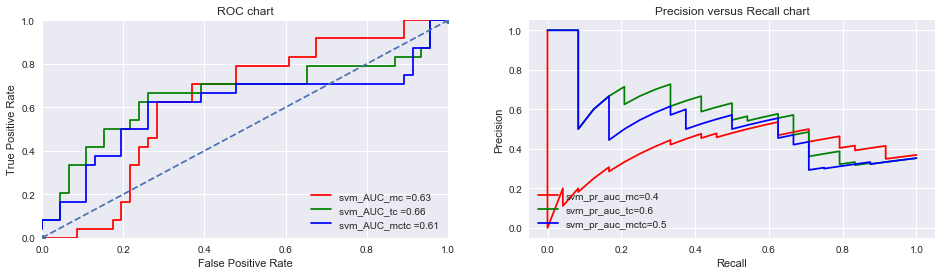

In [20]:
fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(16)

axes = fig.add_subplot(121)

plt.title("ROC chart")
plt.plot(svm_fpr_mc, svm_tpr_mc, 'r', label='svm_AUC_mc =%0.2f'% svm_roc_auc_mc)
plt.plot(svm_fpr_tc, svm_tpr_tc, 'g', label='svm_AUC_tc =%0.2f'% svm_roc_auc_tc)
plt.plot(svm_fpr_mctc, svm_tpr_mctc, 'b', label='svm_AUC_mctc =%0.2f'% svm_roc_auc_mctc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'o--')
plt.axis([0,1, 0,1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")


axes = fig.add_subplot(122)
plt.title("Precision versus Recall chart")
plt.plot(svm_recall_mc, svm_precision_mc, "r", label = 'svm_pr_auc_mc=%.1f' % (svm_pr_auc_mc))
plt.plot(svm_recall_tc, svm_precision_tc, "g", label = 'svm_pr_auc_tc=%.1f' % (svm_pr_auc_tc))
plt.plot(svm_recall_mctc, svm_precision_mctc, "b", label = 'svm_pr_auc_mctc=%.1f' % (svm_pr_auc_mctc))
plt.legend(loc='lower left')
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show();

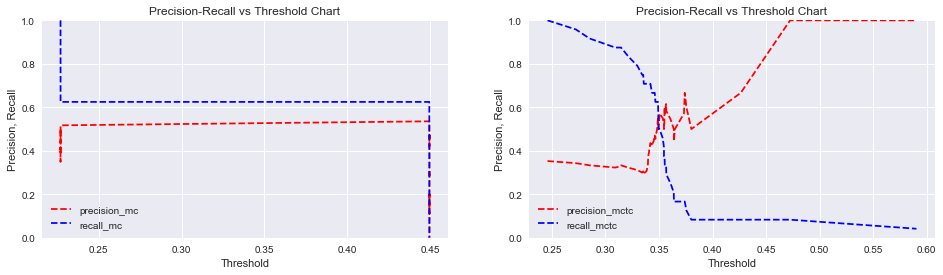

In [21]:
fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(16)

axes = fig.add_subplot(121)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(svm_thresholds_mc, svm_precision_mc[: -1], "r--", label="precision_mc")
plt.plot(svm_thresholds_mc, svm_recall_mc[: -1], "b--", label="recall_mc")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])


axes = fig.add_subplot(122)
plt.title("Precision-Recall vs Threshold Chart")
plt.plot(svm_thresholds_mctc, svm_precision_mctc[: -1], "r--", label="precision_mctc")
plt.plot(svm_thresholds_mctc, svm_recall_mctc[: -1], "b--", label="recall_mctc")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])


plt.show();

#### Adjust thresholds manually and re-evaluate metrics
Note: Default threshold (for classification = 1 i.e., "mostDILI" drug) is P>0.5. In below section, threshold is weakedt to <0.5 for enhancing model performance w.r.t. sensitivity and model metrics re-calculated

**Threshold>0.45**

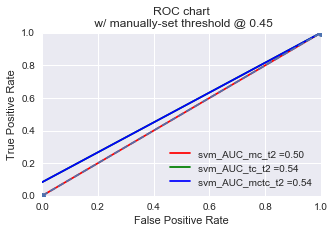

In [22]:
 #Adjust threshold for each of the models
svm_pred_mcy_t2=(svm_mc.predict_proba(test_mcx) [:, 1]>=0.45).astype(bool)

svm_pred_tcy_t2=(svm_tc.predict_proba(test_tcx) [:, 1]>=0.45).astype(bool)

svm_pred_mctcy_t2=(svm_mctc.predict_proba(test_mctcx) [:, 1]>=0.45).astype(bool)

#plot ROC curve based on adjusted thresholds )using predicitons instead of probabilities)

svm_fpr_mc_t2,svm_tpr_mc_t2, svm_thresholds_mc_t2=roc_curve(test_mcy, svm_pred_mcy_t2)
svm_roc_auc_mc_t2=metrics.auc(svm_fpr_mc_t2, svm_tpr_mc_t2)

svm_fpr_tc_t2,svm_tpr_tc_t2, svm_thresholds_tc_t2=roc_curve(test_tcy, svm_pred_tcy_t2)
svm_roc_auc_tc_t2=metrics.auc(svm_fpr_tc_t2, svm_tpr_tc_t2)

svm_fpr_mctc_t2,svm_tpr_mctc_t2, svm_thresholds_mctc_t2=roc_curve(test_mctcy, svm_pred_mctcy_t2)
svm_roc_auc_mctc_t2=metrics.auc(svm_fpr_mctc_t2, svm_tpr_mctc_t2)

fig = plt.figure()
fig.set_figheight(3)
fig.set_figwidth(5)

plt.title("ROC chart\n w/ manually-set threshold @ 0.45")
plt.plot(svm_fpr_mc_t2, svm_tpr_mc_t2, 'r', label='svm_AUC_mc_t2 =%0.2f'% svm_roc_auc_mc_t2)
plt.plot(svm_fpr_tc_t2, svm_tpr_tc_t2, 'g', label='svm_AUC_tc_t2 =%0.2f'% svm_roc_auc_tc_t2)
plt.plot(svm_fpr_mctc_t2, svm_tpr_mctc_t2, 'b', label='svm_AUC_mctc_t2 =%0.2f'% svm_roc_auc_mctc_t2)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'o--')
plt.axis([0,1, 0,1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")

plt.show(); 

In [23]:
### Accuracy, Precision, Recall with modified threshold (t2)
svm_acc_mc_t2=round(metrics.accuracy_score(test_mcy, svm_pred_mcy_t2), 2)
print("Overall accuracy with mc dataset and modified threshold of P>=0.45: " + str(svm_acc_mc_t2)+"\n")

svm_cr_mc_t2=metrics.classification_report(test_mcy, svm_pred_mcy_t2)
print("Classification report with mc dataset and modified threshold of P>=0.45: ")
print(svm_cr_mc_t2)    
print("***************")


svm_acc_tc_t2=round(metrics.accuracy_score(test_tcy, svm_pred_tcy_t2), 2)
print("Overall accuracy with tc dataset and modified threshold of P>=0.45: " + str(svm_acc_tc_t2)+"\n")

svm_cr_tc_t2=metrics.classification_report(test_tcy, svm_pred_tcy_t2)
print("Classification report with tc dataset and modified threshold of P>=0.45: ")
print(svm_cr_tc_t2)   
print("***************")


svm_acc_mctc_t2=round(metrics.accuracy_score(test_mctcy, svm_pred_mctcy_t2), 2)
print("Overall accuracy with mctc dataset and modified threshold of P>=0.45: " + str(svm_acc_mctc_t2)+"\n")

svm_cr_mctc_t2=metrics.classification_report(test_mctcy, svm_pred_mctcy_t2)
print("Classification report with mctc dataset and modified threshold of P>=0.45: ")
print(svm_cr_mctc_t2) 

Overall accuracy with mc dataset and modified threshold of P>=0.45: 0.66

Classification report with mc dataset and modified threshold of P>=0.45: 
             precision    recall  f1-score   support

          0       0.66      1.00      0.79        46
          1       0.00      0.00      0.00        24

avg / total       0.43      0.66      0.52        70

***************
Overall accuracy with tc dataset and modified threshold of P>=0.45: 0.69

Classification report with tc dataset and modified threshold of P>=0.45: 
             precision    recall  f1-score   support

          0       0.68      1.00      0.81        46
          1       1.00      0.08      0.15        24

avg / total       0.79      0.69      0.58        70

***************
Overall accuracy with mctc dataset and modified threshold of P>=0.45: 0.69

Classification report with mctc dataset and modified threshold of P>=0.45: 
             precision    recall  f1-score   support

          0       0.68      1.00    

C:\Users\Sri Bandhakavi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [24]:
###Specificity with modified threshold (t2)
from sklearn.metrics import confusion_matrix

tn_mc_t2, fp_mc_t2, fn_mc_t2, tp_mc_t2 = confusion_matrix(test_mcy, svm_pred_mcy_t2).ravel()
specificity_mc_t2 = tn_mc_t2 / (tn_mc_t2+fp_mc_t2)
print("Specificity for model with modified threshold of P>=0.45 and mc variables alone")
round(specificity_mc_t2,3)


tn_tc_t2, fp_tc_t2, fn_tc_t2, tp_tc_t2 = confusion_matrix(test_tcy, svm_pred_tcy_t2).ravel()
specificity_tc_t2 = tn_tc_t2 / (tn_tc_t2+fp_tc_t2)
print("Specificity for model with modified threshold of P>=0.45 and tc variables alone")
round(specificity_tc_t2,3)

tn_mctc_t2, fp_mctc_t2, fn_mctc_t2, tp_mctc_t2 = confusion_matrix(test_mctcy, svm_pred_mctcy_t2).ravel()
specificity_mctc_t2 = tn_mctc_t2 / (tn_mctc_t2+fp_mctc_t2)
print("specificity for model with modified threshold of P>=0.45 and mctc variables")
round(specificity_mctc_t2, 3)

Specificity for model with modified threshold of P>=0.45 and mc variables alone


1.0

Specificity for model with modified threshold of P>=0.45 and tc variables alone


1.0

specificity for model with modified threshold of P>=0.45 and mctc variables


1.0

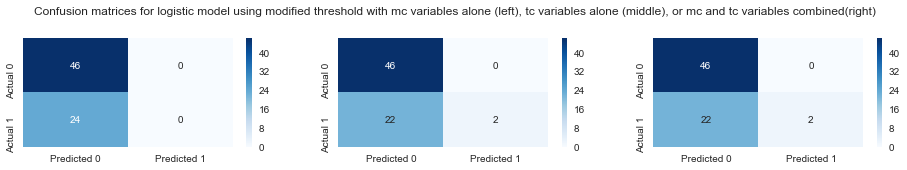

In [25]:
### Confusion Matrix with modified threshold (t2)
svm_cfm_mc_t2=metrics.confusion_matrix(test_mcy, svm_pred_mcy_t2)
svm_cfm_tc_t2=metrics.confusion_matrix(test_tcy, svm_pred_tcy_t2)
svm_cfm_mctc_t2=metrics.confusion_matrix(test_mctcy, svm_pred_mctcy_t2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,2))

lbl1=["Predicted 0", "Predicted 1"]
lbl2=["Actual 0", "Actual 1"]

sns.heatmap(svm_cfm_mc_t2, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2, ax=ax1)
sns.heatmap(svm_cfm_tc_t2, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2, ax=ax2)
sns.heatmap(svm_cfm_mctc_t2, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2, ax=ax3)


fig.suptitle("Confusion matrices for logistic model using modified threshold with mc variables alone (left), tc variables alone (middle), or mc and tc variables combined(right)", y=1.1);  

**Threshold>=0.43**

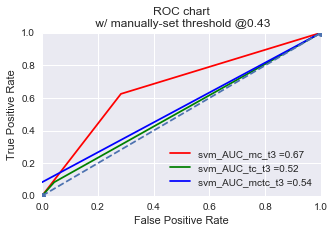

In [26]:
#Adjust threshold for each of the models
svm_pred_mcy_t3=(svm_mc.predict_proba(test_mcx) [:, 1]>=0.43).astype(bool)

svm_pred_tcy_t3=(svm_tc.predict_proba(test_tcx) [:, 1]>=0.43).astype(bool)

svm_pred_mctcy_t3=(svm_mctc.predict_proba(test_mctcx) [:, 1]>=0.43).astype(bool)

#plot ROC curve based on adjusted thresholds using predicitons instead of probabilities)

svm_fpr_mc_t3,svm_tpr_mc_t3, svm_thresholds_mc_t3=roc_curve(test_mcy, svm_pred_mcy_t3)
svm_roc_auc_mc_t3=metrics.auc(svm_fpr_mc_t3, svm_tpr_mc_t3)

svm_fpr_tc_t3,svm_tpr_tc_t3, svm_thresholds_tc_t3=roc_curve(test_tcy, svm_pred_tcy_t3)
svm_roc_auc_tc_t3=metrics.auc(svm_fpr_tc_t3, svm_tpr_tc_t3)

svm_fpr_mctc_t3,svm_tpr_mctc_t3, svm_thresholds_mctc_t3=roc_curve(test_mctcy, svm_pred_mctcy_t3)
svm_roc_auc_mctc_t3=metrics.auc(svm_fpr_mctc_t3, svm_tpr_mctc_t3)

fig = plt.figure()
fig.set_figheight(3)
fig.set_figwidth(5)

plt.title("ROC chart\n w/ manually-set threshold @0.43")
plt.plot(svm_fpr_mc_t3, svm_tpr_mc_t3, 'r', label='svm_AUC_mc_t3 =%0.2f'% svm_roc_auc_mc_t3)
plt.plot(svm_fpr_tc_t3, svm_tpr_tc_t3, 'g', label='svm_AUC_tc_t3 =%0.2f'% svm_roc_auc_tc_t3)
plt.plot(svm_fpr_mctc_t3, svm_tpr_mctc_t3, 'b', label='svm_AUC_mctc_t3 =%0.2f'% svm_roc_auc_mctc_t3)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'o--')
plt.axis([0,1, 0,1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")

plt.show();   

In [27]:
### Accuracy, Precision, Recall with modified threshold (t3)
svm_acc_mc_t3=round(metrics.accuracy_score(test_mcy, svm_pred_mcy_t3), 2)
print("Overall accuracy with mc dataset and modified threshold of P>=0.43: " + str(svm_acc_mc_t3)+"\n")

svm_cr_mc_t3=metrics.classification_report(test_mcy, svm_pred_mcy_t3)
print("Classification report with mc dataset and modified threshold of P>=0.43: ")
print(svm_cr_mc_t3)    
print("***************")


svm_acc_tc_t3=round(metrics.accuracy_score(test_tcy, svm_pred_tcy_t3), 2)
print("Overall accuracy with tc dataset and modified threshold of P>=0.43: " + str(svm_acc_tc_t3)+"\n")

svm_cr_tc_t3=metrics.classification_report(test_tcy, svm_pred_tcy_t3)
print("Classification report with tc dataset and modified threshold of P>=0.43: ")
print(svm_cr_tc_t3)   
print("***************")


svm_acc_mctc_t3=round(metrics.accuracy_score(test_mctcy, svm_pred_mctcy_t3), 2)
print("Overall accuracy with mctc dataset and modified threshold of P>=0.43: " + str(svm_acc_mctc_t3)+"\n")

svm_cr_mctc_t3=metrics.classification_report(test_mctcy, svm_pred_mctcy_t3)
print("Classification report with mctc dataset and modified threshold of P>=0.43: ")
print(svm_cr_mctc_t3) 

Overall accuracy with mc dataset and modified threshold of P>=0.43: 0.69

Classification report with mc dataset and modified threshold of P>=0.43: 
             precision    recall  f1-score   support

          0       0.79      0.72      0.75        46
          1       0.54      0.62      0.58        24

avg / total       0.70      0.69      0.69        70

***************
Overall accuracy with tc dataset and modified threshold of P>=0.43: 0.66

Classification report with tc dataset and modified threshold of P>=0.43: 
             precision    recall  f1-score   support

          0       0.67      0.96      0.79        46
          1       0.50      0.08      0.14        24

avg / total       0.61      0.66      0.57        70

***************
Overall accuracy with mctc dataset and modified threshold of P>=0.43: 0.69

Classification report with mctc dataset and modified threshold of P>=0.43: 
             precision    recall  f1-score   support

          0       0.68      1.00    

In [28]:
###Specificity with modified threshold (t3)
from sklearn.metrics import confusion_matrix

tn_mc_t3, fp_mc_t3, fn_mc_t3, tp_mc_t3 = confusion_matrix(test_mcy, svm_pred_mcy_t3).ravel()
specificity_mc_t3 = tn_mc_t3 / (tn_mc_t3+fp_mc_t3)
print("Specificity for model with modified threshold of P>=0.43 and mc variables alone")
round(specificity_mc_t3,3)


tn_tc_t3, fp_tc_t3, fn_tc_t3, tp_tc_t3 = confusion_matrix(test_tcy, svm_pred_tcy_t3).ravel()
specificity_tc_t3 = tn_tc_t3 / (tn_tc_t3+fp_tc_t3)
print("Specificity for model with modified threshold of P>=0.43 and tc variables alone")
round(specificity_tc_t3,3)

tn_mctc_t3, fp_mctc_t3, fn_mctc_t3, tp_mctc_t3 = confusion_matrix(test_mctcy, svm_pred_mctcy_t3).ravel()
specificity_mctc_t3 = tn_mctc_t3 / (tn_mctc_t3+fp_mctc_t3)
print("specificity for model with modified threshold of P>=0.43 and mctc variables")
round(specificity_mctc_t3, 3)   

Specificity for model with modified threshold of P>=0.43 and mc variables alone


0.717

Specificity for model with modified threshold of P>=0.43 and tc variables alone


0.957

specificity for model with modified threshold of P>=0.43 and mctc variables


1.0